# VND Money Classify
In this lab, I will try to build my first ML application that can classify VND bank notes on my local computer! 

You will follow the general machine learning workflow.

1. Explore data
2. Build an input pipeline with tf.data.Dataset
3. Build my model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
4. Train 
5. Fine tune


## Build the dataset

### Download the dataset

In [1]:
# improt library
import tensorflow as tf
tf.executing_eagerly()
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [9]:
import gdown
url = 'https://drive.google.com/uc?id=1PKpYaXZL_LoCU8T8JUc9DuSd5iRBG4zJ'
output = 'money.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1PKpYaXZL_LoCU8T8JUc9DuSd5iRBG4zJ
To: d:\Giang_vu\money.zip


























































































































































































































































































































































































































































































































































































































































































































































































































































































































'money.zip'

In [10]:
# Unzip
import zipfile
with zipfile.ZipFile("money.zip","r") as zip_ref:
  zip_ref.extractall('datadir')

992MB [21:04, 785kB/s] 
2.00GB [16:25, 2.03MB/s]
62.2MB [10:40, 97.1kB/s]


In [4]:
image_ds =  tf.data.Dataset.list_files('datadir/*/*', shuffle=False)

In [5]:
image_ds 

<TensorSliceDataset shapes: (), types: tf.string>

In [6]:
def get_labels(file_path):
  return tf.strings.split(file_path, os.path.sep)[-2]

In [7]:
def parse_label(label):
    if label == '1000':
        return 0
    elif label == '10000':
        return 1
    elif label == '100000':
        return 2
    elif label == '2000':
        return 3
    elif label == '20000':
        return 4
    elif label == '200000':
        return 5
    elif label == '5000':
        return 6
    elif label == '50000':
        return 7
    else:
        return 8

In [8]:
# function process image
def preprocess_image(file_path):
  label = get_labels(file_path)
  label = parse_label(label)
  img = tf.io.read_file(file_path)
  img = tf.image.decode_image(img,expand_animations=False,channels=3)
  img = tf.image.resize(img,[224,224])
  img = img/255
  return img, label

In [9]:
# function augmentation
def image_aug(img,label):
  image = tf.image.random_contrast(img, 0.5, 1)
  image = tf.image.random_brightness(img, 0.5)
  return img, label

In [10]:
# very important it affect accuracy of val_ds
image_ds = image_ds.shuffle(1000,seed=42)

In [11]:
# print out file in image_ds
for file in image_ds.take(3):
  print(file)

tf.Tensor(b'datadir\\10000\\20190827_121004.jpg', shape=(), dtype=string)
tf.Tensor(b'datadir\\2000\\ia_600000043.jpg', shape=(), dtype=string)
tf.Tensor(b'datadir\\10000\\1566902353.346648.jpg', shape=(), dtype=string)


In [10]:
image_count = len(image_ds)
image_count

1713

In [11]:
# split train_test 
train_size = int(image_count*0.8)
train_ds = image_ds.take(train_size)
test_ds = image_ds.skip(train_size)

In [12]:
train_ds = train_ds.map(preprocess_image).shuffle(1000,seed=42).batch(32).map(image_aug).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = test_ds.map(preprocess_image).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
train_ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [14]:
image, label = next(iter(train_ds.take(1)))

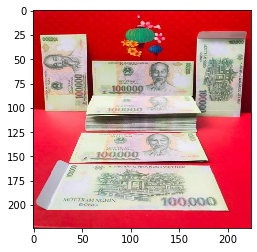

In [15]:
# show image
plt.imshow(image[0])

### Use data augmentation

In [16]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(.5, .2)
])

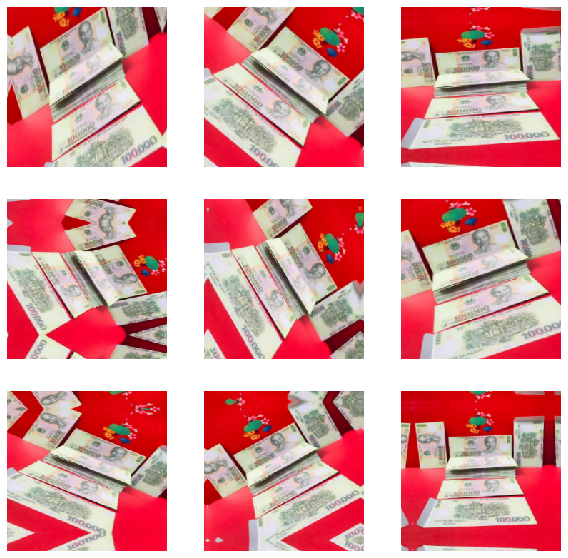

In [17]:
# Display some augmentation from a photo
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

## Build the Model using Transfer Learning - Model: Mobilenet V2

In [34]:
base_model = tf.keras.applications.MobileNetV2(weights="imagenet",
                                              input_shape=(224, 224, 3), 
                                              include_top=False)
# Freeze the base model
base_model.trainable=False

In [41]:
def model_maker():
  inputs = tf.keras.Input(shape=(224,224, 3))
  x = data_augmentation(inputs)
  x = base_model(x, training=False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs =  tf.keras.layers.Dense(9, activation='softmax')(x)
  model = tf.keras.Model(inputs, outputs)
  return model

In [42]:
model = model_maker()

In [43]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 11529     
Total params: 2,269,513
Trainable params: 11,529
Non-trainable params: 2,257,984
____________________________________________

In [44]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [45]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                          restore_best_weights=True,
                                                          min_delta=1e-2,
                                                          patience=10,
                                                          verbose=1)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath="my_model_checkpoint{epoch}.h5",
                                                        save_weights_only=False, # the whole model (False) or only weights (True) 
                                                        save_best_only=True, # keep the best model with lowest validation loss
                                                        monitor='val_loss',
                                                        verbose=1)

callbacks = [earlystopping_callback,checkpoint_callback]
# using callbacks

In [46]:
# train model with 5 epochs
epochs=5
history = model.fit(train_ds,               # <<<<<<<
                    validation_data=val_ds, # <<<<<<<,
                    epochs=epochs,
                    callbacks= callbacks,
                    verbose =1)

Epoch 1/5
43/43 [==============================] - 55s 936ms/step - loss: 1.5311 - accuracy: 0.4759 - val_loss: 0.9057 - val_accuracy: 0.7638

Epoch 00001: val_loss improved from inf to 0.90567, saving model to my_model_checkpoint1.h5
Epoch 2/5
43/43 [==============================] - 55s 972ms/step - loss: 0.8322 - accuracy: 0.7321 - val_loss: 0.6833 - val_accuracy: 0.8222

Epoch 00002: val_loss improved from 0.90567 to 0.68330, saving model to my_model_checkpoint2.h5
Epoch 3/5
43/43 [==============================] - 57s 957ms/step - loss: 0.6582 - accuracy: 0.8000 - val_loss: 0.5809 - val_accuracy: 0.8367

Epoch 00003: val_loss improved from 0.68330 to 0.58089, saving model to my_model_checkpoint3.h5
Epoch 4/5
43/43 [==============================] - 57s 1s/step - loss: 0.5335 - accuracy: 0.8474 - val_loss: 0.5517 - val_accuracy: 0.8455

Epoch 00004: val_loss improved from 0.58089 to 0.55168, saving model to my_model_checkpoint4.h5
Epoch 5/5
43/43 [==============================] - 

## Fine tune model

In [2]:
restored_model = tf.keras.models.load_model('my_model_checkpoint5.h5')

In [48]:
# Unfreeze the base_model.
base_model.trainable = True

# Fine-tune from 
fine_tune_at = 143

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

restored_model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

restored_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 11529     
Total params: 2,269,513
Trainable params: 11,529
Non-trainable params: 2,257,984
____________________________________________

In [49]:
init_epochs = 5
fine_tune_epochs = 20
total_epochs = init_epochs + fine_tune_epochs

history_fine = restored_model.fit(train_ds, 
                         validation_data=val_ds,
                         epochs=total_epochs,
                         initial_epoch=init_epochs,
                         callbacks=callbacks)

Epoch 6/25
43/43 [==============================] - 56s 958ms/step - loss: 0.4083 - accuracy: 0.8847 - val_loss: 0.4473 - val_accuracy: 0.8776

Epoch 00006: val_loss did not improve from 0.38261
Epoch 7/25
43/43 [==============================] - 56s 992ms/step - loss: 0.3531 - accuracy: 0.9066 - val_loss: 0.3250 - val_accuracy: 0.9184

Epoch 00007: val_loss improved from 0.38261 to 0.32496, saving model to my_model_checkpoint7.h5
Epoch 8/25
43/43 [==============================] - 54s 988ms/step - loss: 0.3349 - accuracy: 0.9015 - val_loss: 0.3690 - val_accuracy: 0.9067

Epoch 00008: val_loss did not improve from 0.32496
Epoch 9/25
43/43 [==============================] - 53s 963ms/step - loss: 0.3126 - accuracy: 0.9124 - val_loss: 0.2834 - val_accuracy: 0.9242

Epoch 00009: val_loss improved from 0.32496 to 0.28339, saving model to my_model_checkpoint9.h5
Epoch 10/25
43/43 [==============================] - 53s 955ms/step - loss: 0.2809 - accuracy: 0.9277 - val_loss: 0.3157 - val_acc

In [51]:
restored_model.evaluate(val_ds)

11/11 [==============================] - 8s 655ms/step - loss: 0.1422 - accuracy: 0.9738


[0.14215247333049774, 0.9737609624862671]